# Project: Dog vs Cat Classification

In [106]:
from pathlib import Path
import os
import torch
from torch import nn

In [107]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [108]:
data_path = Path("data/")
train_path = data_path / "train"
test_path = data_path / "test"

train_path, test_path

(WindowsPath('data/train'), WindowsPath('data/test'))

In [109]:
from PIL import Image
import random
import matplotlib.pyplot as plt
import numpy as np

Text(0.5, 1.0, 'Dog, Shape: (333, 500, 3)')

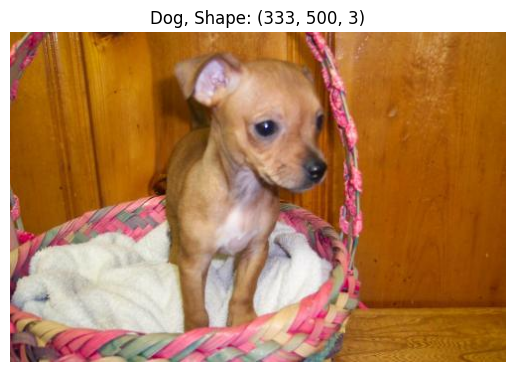

In [110]:
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
image_path_list = list(data_path.glob("*/*/*.jpg"))

random_image_path = random.choice(image_path_list)

image_class = random_image_path.parent.stem

img = Image.open(random_image_path)
img_is_array = np.asarray(img)

plt.imshow(img)
plt.axis(False)
plt.title(f"{image_class}, Shape: {img_is_array.shape}")

In [111]:
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

In [112]:
data_transform = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])

test_data_transform = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.ToTensor()
])

In [113]:
transformed_image = data_transform(img)
transformed_image

tensor([[[0.6118, 0.6431, 0.6627,  ..., 0.6039, 0.6078, 0.6196],
         [0.6196, 0.6314, 0.6588,  ..., 0.5961, 0.6431, 0.6392],
         [0.6235, 0.6353, 0.6549,  ..., 0.5451, 0.6196, 0.7333],
         ...,
         [0.5333, 0.5294, 0.5451,  ..., 0.3294, 0.4314, 0.3412],
         [0.5725, 0.5686, 0.5765,  ..., 0.3176, 0.4353, 0.3608],
         [0.5725, 0.5843, 0.6039,  ..., 0.3373, 0.5059, 0.4706]],

        [[0.3725, 0.4000, 0.4078,  ..., 0.3843, 0.4078, 0.3765],
         [0.3765, 0.3882, 0.4039,  ..., 0.2353, 0.4431, 0.3882],
         [0.3765, 0.3922, 0.4039,  ..., 0.1412, 0.3882, 0.4431],
         ...,
         [0.3137, 0.3176, 0.3255,  ..., 0.1961, 0.1961, 0.1294],
         [0.3529, 0.3529, 0.3569,  ..., 0.2039, 0.2078, 0.1686],
         [0.3529, 0.3647, 0.3804,  ..., 0.2039, 0.2627, 0.2549]],

        [[0.0549, 0.0745, 0.0863,  ..., 0.2980, 0.0784, 0.0118],
         [0.0549, 0.0627, 0.0784,  ..., 0.2941, 0.2235, 0.0431],
         [0.0510, 0.0667, 0.0745,  ..., 0.2510, 0.3373, 0.

Text(0.5, 1.0, 'Dog, Shape: torch.Size([3, 64, 64])')

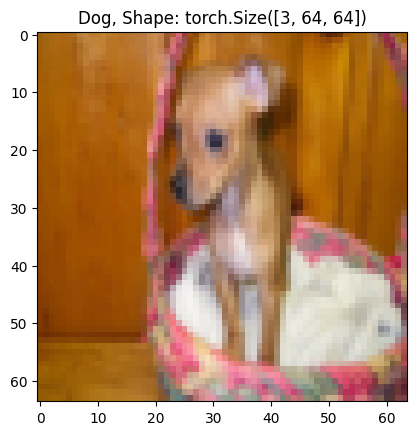

In [114]:
plt.imshow(transformed_image.permute(1, 2, 0))
plt.title(f"{image_class}, Shape: {transformed_image.shape}")

# Loading data using 'ImageFolder'

In [115]:
train_data = datasets.ImageFolder(root=train_path,
                                  transform=data_transform)

test_data = datasets.ImageFolder(root=test_path,
                                 transform=test_data_transform)

train_data, test_data

(Dataset ImageFolder
     Number of datapoints: 3566
     Root location: data\train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 834
     Root location: data\test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                ToTensor()
            ))

In [116]:
# Get class names as list
class_names = train_data.classes
class_names

['Cat', 'Dog']

In [117]:
# Get class names as dictionary 
class_dict = train_data.class_to_idx
class_dict

{'Cat': 0, 'Dog': 1}

In [118]:
len(train_data), len(test_data)

(3566, 834)

# Turn loaded images into 'DataLoader'

In [119]:
BATCH_SIZE = 32
NUM_WORKERS = 0

train_dataloader = DataLoader(dataset=train_data,
                              batch_size=BATCH_SIZE,
                              num_workers=NUM_WORKERS,
                              shuffle=True)

test_dataloader = DataLoader(dataset=test_data,
                             batch_size=BATCH_SIZE,
                             num_workers=NUM_WORKERS,
                             shuffle=False)

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x25bb7e1b700>,
 <torch.utils.data.dataloader.DataLoader at 0x25bb83ea9d0>)

In [120]:
img_custom, label_custom = next(iter(train_dataloader))

img_custom.shape, label_custom.shape

(torch.Size([32, 3, 64, 64]), torch.Size([32]))

In [121]:
class DogVsCat(nn.Module):
    def __init__(self, input_shape, hidden_layers, output_shape):
        super().__init__()

        self.conv_block_layer_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape,
                      out_channels=hidden_layers,
                      kernel_size=3,
                      padding=1,
                      stride=1),
            nn.BatchNorm2d(num_features=hidden_layers),
            nn.ReLU(),
            #nn.Dropout(p=0.2),
            nn.Conv2d(in_channels=hidden_layers,
                      out_channels=hidden_layers * 2,
                      kernel_size=3,
                      padding=1,
                      stride=1),
            nn.BatchNorm2d(num_features=hidden_layers*2),
            nn.ReLU(),
            #nn.Dropout(p=0.2),
            nn.MaxPool2d(kernel_size=2,
                         stride=2)
        )

        self.conv_block_layer_2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_layers*2,
                      out_channels=hidden_layers*2*2,
                      kernel_size=3,
                      padding=1,
                      stride=1),
            nn.BatchNorm2d(num_features=hidden_layers*2*2),
            nn.ReLU(),
            #nn.Dropout(p=0.2),
            nn.Conv2d(in_channels=hidden_layers*2*2,
                      out_channels=hidden_layers*2*2*2,
                      kernel_size=3,
                      padding=1,
                      stride=1),
            nn.BatchNorm2d(num_features=hidden_layers*2*2*2),
            nn.ReLU(),
           # nn.Dropout(p=0.2),
            nn.MaxPool2d(kernel_size=2,
                         stride=2)
        )

        self.classification = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_layers*16*16*8,
                      #out_features=output_shape
                      out_features=128),
            nn.ReLU(),
            nn.Linear(128, output_shape)
        )

    def forward(self, x):
        #print(f"Shape: {x.shape}")
        x = self.conv_block_layer_1(x)
        #print(f"Shape: {x.shape}")
        x = self.conv_block_layer_2(x)
        #print(f"Shape: {x.shape}")
        x = self.classification(x)
        #print(f"Shape: {x.shape}")
        return x
        

In [122]:
model_0 = DogVsCat(input_shape=3, hidden_layers=16, output_shape=1).to(device)
model_0

DogVsCat(
  (conv_block_layer_1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_layer_2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classification): S

In [123]:
# Setup loss function and optimizer
loss_fn = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(params=model_0.parameters(),
                             lr=0.001)

loss_fn, optimizer

(BCEWithLogitsLoss(),
 Adam (
 Parameter Group 0
     amsgrad: False
     betas: (0.9, 0.999)
     capturable: False
     differentiable: False
     eps: 1e-08
     foreach: None
     fused: None
     lr: 0.001
     maximize: False
     weight_decay: 0
 ))

In [124]:
# Check the correct shape on dummy tensor
dummy_input = torch.randn(32, 3, 64, 64)
output = model_0(dummy_input.to(device))
output

tensor([[-0.0983],
        [-0.0540],
        [-0.0876],
        [ 0.0483],
        [-0.1699],
        [-0.0690],
        [-0.1521],
        [-0.1965],
        [-0.1683],
        [-0.2054],
        [-0.1317],
        [-0.1733],
        [-0.3395],
        [ 0.0301],
        [-0.2089],
        [-0.1926],
        [-0.3380],
        [-0.3078],
        [-0.2271],
        [-0.2791],
        [-0.5015],
        [-0.5743],
        [-0.3036],
        [-0.1471],
        [-0.1844],
        [-0.1641],
        [-0.2957],
        [-0.1916],
        [-0.0449],
        [-0.1620],
        [-0.4365],
        [-0.1333]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [125]:
from tqdm import tqdm
import time

In [126]:
epochs = 5

start_time = time.time()

results = {"train_loss": [],
               "train_acc": [],
               "test_loss": [],
               "test_acc": []}

for epoch in tqdm(range(epochs)):

    model_0.train()
    train_loss, train_acc = 0, 0
    
    for batch, (X, y) in enumerate(train_dataloader):
        X, y = X.to(device), y.to(device)

        y = y.unsqueeze(dim=1).float()
        
        y_pred = model_0(X)

        loss = loss_fn(y_pred, y)
        train_loss += loss.item()
        
        optimizer.zero_grad()

        loss.backward()

        optimizer.step()

        y_pred_class = (torch.sigmoid(y_pred) > 0.5).float()
        train_acc += (y_pred_class==y).sum().item() / len(y_pred)

    train_loss /= len(train_dataloader)
    train_acc = (train_acc / len(train_dataloader)) * 100
    
    model_0.eval()
    test_loss, test_acc = 0, 0
    
    with torch.inference_mode():
        for batch, (X, y) in enumerate(test_dataloader):
            X, y = X.to(device), y.to(device)

            y = y.unsqueeze(dim=1).float()
        
            test_pred = model_0(X)

            loss = loss_fn(test_pred, y)
            test_loss += loss.item()

            test_pred_class = (torch.sigmoid(test_pred) > 0.5).float()
            test_acc += (test_pred_class==y).sum().item() / len(test_pred)
    
        test_loss /= len(test_dataloader)
        test_acc = (test_acc / len(test_dataloader)) * 100

    print(f"Epoch: {epoch} | Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.2f} | Test Loss: {test_loss}, Test Accuracy: {test_acc}")

    results["train_loss"].append(train_loss)
    results["train_acc"].append(train_acc)
    results["test_loss"].append(test_loss)
    results["test_acc"].append(test_acc)
    


end_time = time.time()
train_time = end_time - start_time

print(f"Total time: {train_time}")

 20%|██        | 1/5 [00:10<00:41, 10.44s/it]

Epoch: 0 | Train Loss: 1.3518, Train Accuracy: 54.95 | Test Loss: 0.6590791521248994, Test Accuracy: 62.84722222222222


 40%|████      | 2/5 [00:20<00:30, 10.16s/it]

Epoch: 1 | Train Loss: 0.6796, Train Accuracy: 62.36 | Test Loss: 0.6429171954040174, Test Accuracy: 67.24537037037037


 60%|██████    | 3/5 [00:31<00:21, 10.68s/it]

Epoch: 2 | Train Loss: 0.6435, Train Accuracy: 65.65 | Test Loss: 0.8636450924807124, Test Accuracy: 57.06018518518518


 80%|████████  | 4/5 [00:41<00:10, 10.42s/it]

Epoch: 3 | Train Loss: 0.5933, Train Accuracy: 69.03 | Test Loss: 0.5330891311168671, Test Accuracy: 73.8425925925926


100%|██████████| 5/5 [00:51<00:00, 10.30s/it]

Epoch: 4 | Train Loss: 0.5559, Train Accuracy: 72.28 | Test Loss: 0.5557587499971743, Test Accuracy: 71.29629629629629
Total time: 51.49280023574829


# Plot model_0 results

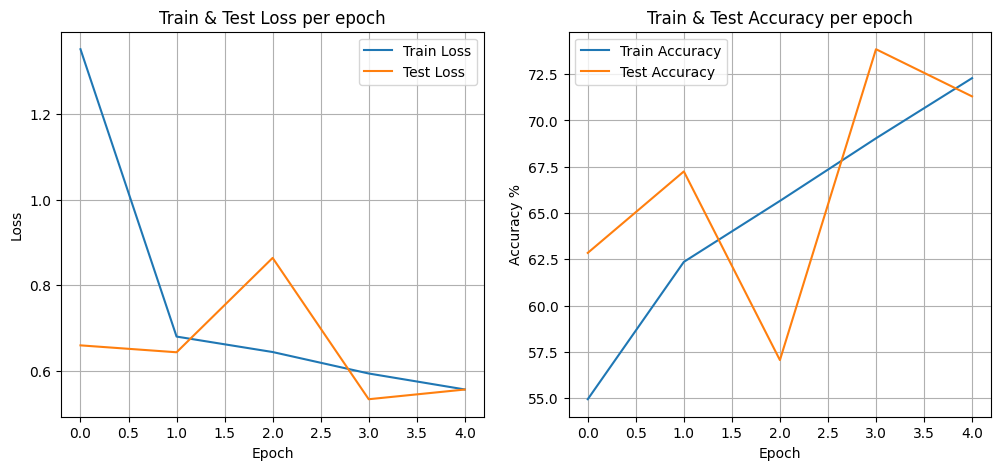

In [127]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(range(epochs), results["train_loss"], label="Train Loss")
plt.plot(range(epochs), results["test_loss"], label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Train & Test Loss per epoch")
plt.legend()
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(range(epochs), results["train_acc"], label="Train Accuracy")
plt.plot(range(epochs), results["test_acc"], label="Test Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy %")
plt.title("Train & Test Accuracy per epoch")
plt.legend()
plt.grid()



In [128]:
print(len(results["train_loss"]), len(results["test_loss"]))
print(len(results["train_acc"]), len(results["test_acc"]))

5 5
5 5


In [129]:
# Build train and test function to make training easier
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim,
               device=device):

    train_loss, correct_preds, total_samples = 0, 0, 0
    model.train()

    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        y = y.unsqueeze(dim=1).float()
        
        y_pred = model(X)

        loss = loss_fn(y_pred, y)
        train_loss += loss.item()
        
        optimizer.zero_grad()

        loss.backward()

        optimizer.step()
        
        y_pred_class = (torch.sigmoid(y_pred) > 0.5).float()
        #train_acc += (y_pred_class==y).sum().item() / len(y_pred)
        correct_preds += (y_pred_class == y).sum().item()
        total_samples += y.size(0)

    train_loss /= len(dataloader)
    #train_acc = (train_acc / len(dataloader)) * 100
    train_acc = (correct_preds / total_samples) * 100
    
    return train_loss, train_acc

In [130]:
def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device=device):

    test_loss, correct_preds, total_samples = 0, 0, 0
    model.eval()
    with torch.inference_mode():
        for batch, (X, y) in enumerate(dataloader):
            X, y = X.to(device), y.to(device)

            y = y.unsqueeze(dim=1).float()
        
            test_pred = model(X)

            loss = loss_fn(test_pred, y)
            test_loss += loss.item()

            test_pred_class = (torch.sigmoid(test_pred) > 0.5).float()
            #test_acc += (test_pred_class==y).sum().item() / len(test_pred)
            correct_preds += (test_pred_class == y).sum().item()
            total_samples += y.size(0)
    
    test_loss /= len(dataloader)
    #test_acc = (test_acc / len(dataloader)) * 100
    test_acc = (correct_preds / total_samples) * 100
    return test_loss, test_acc

# Augmentation data

In [131]:
train_data_transform_augmentation = transforms.Compose([
    #transforms.Resize(size=(64, 64)),
    transforms.RandomResizedCrop(size=(64, 64), scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    #transforms.RandomAffine(degrees=15, translate=(1, 1)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31), # used to differentiate the data
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
])

test_data = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
])
train_data_transform_augmentation, test_data

(Compose(
     RandomResizedCrop(size=(64, 64), scale=(0.8, 1.0), ratio=(0.75, 1.3333), interpolation=bilinear, antialias=True)
     RandomHorizontalFlip(p=0.5)
     RandomRotation(degrees=[-15.0, 15.0], interpolation=nearest, expand=False, fill=0)
     ColorJitter(brightness=(0.8, 1.2), contrast=(0.8, 1.2), saturation=(0.8, 1.2), hue=(-0.1, 0.1))
     TrivialAugmentWide(num_magnitude_bins=31, interpolation=InterpolationMode.NEAREST, fill=None)
     ToTensor()
     Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
 ),
 Compose(
     Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
     ToTensor()
     Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
 ))

In [132]:
train_data_augmentation = datasets.ImageFolder(root=train_path,
                                               transform=train_data_transform_augmentation)
test_data_augmentation = datasets.ImageFolder(root=test_path,
                                              transform=test_data)

train_data_augmentation, test_data_augmentation

(Dataset ImageFolder
     Number of datapoints: 3566
     Root location: data\train
     StandardTransform
 Transform: Compose(
                RandomResizedCrop(size=(64, 64), scale=(0.8, 1.0), ratio=(0.75, 1.3333), interpolation=bilinear, antialias=True)
                RandomHorizontalFlip(p=0.5)
                RandomRotation(degrees=[-15.0, 15.0], interpolation=nearest, expand=False, fill=0)
                ColorJitter(brightness=(0.8, 1.2), contrast=(0.8, 1.2), saturation=(0.8, 1.2), hue=(-0.1, 0.1))
                TrivialAugmentWide(num_magnitude_bins=31, interpolation=InterpolationMode.NEAREST, fill=None)
                ToTensor()
                Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
            ),
 Dataset ImageFolder
     Number of datapoints: 834
     Root location: data\test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                ToTensor()
                Norma

In [133]:
BATCH_SIZE = 32
NUM_WORKERS = 0

train_dataloader_augmentation = DataLoader(dataset=train_data_augmentation,
                                           batch_size=BATCH_SIZE,
                                           num_workers=NUM_WORKERS,
                                           shuffle=True)

test_dataloader_augmentation = DataLoader(dataset=test_data_augmentation,
                                          batch_size=BATCH_SIZE,
                                          num_workers=NUM_WORKERS,
                                          shuffle=False)

train_dataloader_augmentation, test_dataloader_augmentation

(<torch.utils.data.dataloader.DataLoader at 0x25b85c164c0>,
 <torch.utils.data.dataloader.DataLoader at 0x25b85c16880>)

In [134]:
len(class_names)

2

In [135]:
model_1 = DogVsCat(input_shape=3, hidden_layers=8, output_shape=1).to(device)
model_1

DogVsCat(
  (conv_block_layer_1): Sequential(
    (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_layer_2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classification): Sequen

In [136]:
# Setup loss function and optimizer
loss_fn = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(params=model_1.parameters(), lr=0.001)
                             #lr=0.00025)
#optimizer = torch.optim.SGD(params=model_1.parameters(), lr=0.01, momentum=0.9)
loss_fn, optimizer

(BCEWithLogitsLoss(),
 Adam (
 Parameter Group 0
     amsgrad: False
     betas: (0.9, 0.999)
     capturable: False
     differentiable: False
     eps: 1e-08
     foreach: None
     fused: None
     lr: 0.001
     maximize: False
     weight_decay: 0
 ))

In [137]:
# Train model_1 on augmentation data
epochs = 50

start_time = time.time()

results = {"train_loss": [],
               "train_acc": [],
               "test_loss": [],
               "test_acc": []}

for epoch in tqdm(range(epochs)):

    train_loss, train_acc = train_step(model=model_1,
               dataloader=train_dataloader_augmentation,
               loss_fn=loss_fn,
               optimizer=optimizer)

    test_loss, test_acc = test_step(model=model_1,
              dataloader=test_dataloader_augmentation,
              loss_fn=loss_fn)

    print(f"Epoch: {epoch} | Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.2f} | Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.2f}")

    results["train_loss"].append(train_loss)
    results["train_acc"].append(train_acc)
    results["test_loss"].append(test_loss)
    results["test_acc"].append(test_acc)
    


end_time = time.time()
train_time = end_time - start_time

print(f"Total time: {train_time}")

  2%|▏         | 1/50 [00:14<11:56, 14.61s/it]

Epoch: 0 | Train Loss: 0.9749, Train Accuracy: 53.56 | Test Loss: 0.6774, Test Accuracy: 56.83


  4%|▍         | 2/50 [00:29<12:01, 15.03s/it]

Epoch: 1 | Train Loss: 0.6806, Train Accuracy: 56.70 | Test Loss: 0.6554, Test Accuracy: 62.23


  6%|▌         | 3/50 [00:44<11:26, 14.60s/it]

Epoch: 2 | Train Loss: 0.6738, Train Accuracy: 58.38 | Test Loss: 0.6361, Test Accuracy: 62.95


  8%|▊         | 4/50 [00:58<11:08, 14.53s/it]

Epoch: 3 | Train Loss: 0.6646, Train Accuracy: 58.10 | Test Loss: 0.6530, Test Accuracy: 59.11


 10%|█         | 5/50 [01:12<10:50, 14.46s/it]

Epoch: 4 | Train Loss: 0.6626, Train Accuracy: 59.73 | Test Loss: 0.6044, Test Accuracy: 66.67


 12%|█▏        | 6/50 [01:27<10:43, 14.62s/it]

Epoch: 5 | Train Loss: 0.6501, Train Accuracy: 61.39 | Test Loss: 0.5998, Test Accuracy: 64.63


 14%|█▍        | 7/50 [01:42<10:25, 14.55s/it]

Epoch: 6 | Train Loss: 0.6347, Train Accuracy: 62.51 | Test Loss: 0.5751, Test Accuracy: 72.06


 16%|█▌        | 8/50 [01:56<10:09, 14.50s/it]

Epoch: 7 | Train Loss: 0.6382, Train Accuracy: 63.35 | Test Loss: 0.5827, Test Accuracy: 67.39


 18%|█▊        | 9/50 [02:10<09:53, 14.47s/it]

Epoch: 8 | Train Loss: 0.6271, Train Accuracy: 63.40 | Test Loss: 0.5969, Test Accuracy: 66.31


 20%|██        | 10/50 [02:25<09:36, 14.41s/it]

Epoch: 9 | Train Loss: 0.6370, Train Accuracy: 63.29 | Test Loss: 0.5764, Test Accuracy: 68.23


 22%|██▏       | 11/50 [02:40<09:28, 14.56s/it]

Epoch: 10 | Train Loss: 0.6236, Train Accuracy: 65.11 | Test Loss: 0.5652, Test Accuracy: 69.54


 24%|██▍       | 12/50 [02:54<09:12, 14.54s/it]

Epoch: 11 | Train Loss: 0.6153, Train Accuracy: 66.24 | Test Loss: 0.5630, Test Accuracy: 70.38


 26%|██▌       | 13/50 [03:08<08:56, 14.50s/it]

Epoch: 12 | Train Loss: 0.6107, Train Accuracy: 67.33 | Test Loss: 0.5377, Test Accuracy: 74.58


 28%|██▊       | 14/50 [03:23<08:46, 14.63s/it]

Epoch: 13 | Train Loss: 0.6050, Train Accuracy: 66.88 | Test Loss: 0.5288, Test Accuracy: 73.62


 30%|███       | 15/50 [03:38<08:29, 14.57s/it]

Epoch: 14 | Train Loss: 0.5963, Train Accuracy: 67.50 | Test Loss: 0.5428, Test Accuracy: 70.86


 32%|███▏      | 16/50 [03:52<08:13, 14.50s/it]

Epoch: 15 | Train Loss: 0.5932, Train Accuracy: 67.30 | Test Loss: 0.5232, Test Accuracy: 73.02


 34%|███▍      | 17/50 [04:07<07:57, 14.48s/it]

Epoch: 16 | Train Loss: 0.5871, Train Accuracy: 68.23 | Test Loss: 0.4920, Test Accuracy: 76.50


 36%|███▌      | 18/50 [04:21<07:40, 14.40s/it]

Epoch: 17 | Train Loss: 0.6044, Train Accuracy: 66.83 | Test Loss: 0.5020, Test Accuracy: 76.86


 38%|███▊      | 19/50 [04:35<07:25, 14.36s/it]

Epoch: 18 | Train Loss: 0.5742, Train Accuracy: 69.57 | Test Loss: 0.5338, Test Accuracy: 69.30


 40%|████      | 20/50 [04:50<07:16, 14.57s/it]

Epoch: 19 | Train Loss: 0.5781, Train Accuracy: 69.52 | Test Loss: 0.4851, Test Accuracy: 74.46


 42%|████▏     | 21/50 [05:05<07:01, 14.55s/it]

Epoch: 20 | Train Loss: 0.5708, Train Accuracy: 69.43 | Test Loss: 0.4953, Test Accuracy: 74.58


 44%|████▍     | 22/50 [05:20<06:53, 14.77s/it]

Epoch: 21 | Train Loss: 0.5684, Train Accuracy: 70.16 | Test Loss: 0.4775, Test Accuracy: 75.66


 46%|████▌     | 23/50 [05:36<06:48, 15.11s/it]

Epoch: 22 | Train Loss: 0.5738, Train Accuracy: 69.43 | Test Loss: 0.4809, Test Accuracy: 75.78


 48%|████▊     | 24/50 [05:51<06:33, 15.14s/it]

Epoch: 23 | Train Loss: 0.5593, Train Accuracy: 70.13 | Test Loss: 0.4963, Test Accuracy: 76.62


 50%|█████     | 25/50 [06:06<06:13, 14.94s/it]

Epoch: 24 | Train Loss: 0.5444, Train Accuracy: 71.31 | Test Loss: 0.5298, Test Accuracy: 73.86


 52%|█████▏    | 26/50 [06:20<05:51, 14.66s/it]

Epoch: 25 | Train Loss: 0.5544, Train Accuracy: 71.70 | Test Loss: 0.4815, Test Accuracy: 75.90


 54%|█████▍    | 27/50 [06:34<05:38, 14.71s/it]

Epoch: 26 | Train Loss: 0.5546, Train Accuracy: 70.98 | Test Loss: 0.4832, Test Accuracy: 75.78


 56%|█████▌    | 28/50 [06:50<05:26, 14.84s/it]

Epoch: 27 | Train Loss: 0.5557, Train Accuracy: 71.40 | Test Loss: 0.4576, Test Accuracy: 77.58


 58%|█████▊    | 29/50 [07:04<05:09, 14.75s/it]

Epoch: 28 | Train Loss: 0.5392, Train Accuracy: 72.55 | Test Loss: 0.5590, Test Accuracy: 72.66


 60%|██████    | 30/50 [07:19<04:58, 14.90s/it]

Epoch: 29 | Train Loss: 0.5422, Train Accuracy: 71.79 | Test Loss: 0.4798, Test Accuracy: 77.34


 62%|██████▏   | 31/50 [07:34<04:41, 14.79s/it]

Epoch: 30 | Train Loss: 0.5446, Train Accuracy: 71.34 | Test Loss: 0.4362, Test Accuracy: 79.26


 64%|██████▍   | 32/50 [07:48<04:24, 14.69s/it]

Epoch: 31 | Train Loss: 0.5452, Train Accuracy: 70.53 | Test Loss: 0.4446, Test Accuracy: 77.46


 66%|██████▌   | 33/50 [08:03<04:08, 14.64s/it]

Epoch: 32 | Train Loss: 0.5159, Train Accuracy: 72.74 | Test Loss: 0.4469, Test Accuracy: 77.22


 68%|██████▊   | 34/50 [08:18<03:55, 14.73s/it]

Epoch: 33 | Train Loss: 0.5281, Train Accuracy: 72.52 | Test Loss: 0.4510, Test Accuracy: 76.62


 70%|███████   | 35/50 [08:32<03:40, 14.70s/it]

Epoch: 34 | Train Loss: 0.5093, Train Accuracy: 74.06 | Test Loss: 0.4277, Test Accuracy: 79.14


 72%|███████▏  | 36/50 [08:47<03:25, 14.70s/it]

Epoch: 35 | Train Loss: 0.5287, Train Accuracy: 72.80 | Test Loss: 0.4726, Test Accuracy: 75.90


 74%|███████▍  | 37/50 [09:04<03:19, 15.35s/it]

Epoch: 36 | Train Loss: 0.5077, Train Accuracy: 74.62 | Test Loss: 0.4639, Test Accuracy: 77.70


 76%|███████▌  | 38/50 [09:20<03:06, 15.54s/it]

Epoch: 37 | Train Loss: 0.5146, Train Accuracy: 73.44 | Test Loss: 0.4190, Test Accuracy: 79.74


 78%|███████▊  | 39/50 [09:37<02:54, 15.91s/it]

Epoch: 38 | Train Loss: 0.5213, Train Accuracy: 73.36 | Test Loss: 0.4260, Test Accuracy: 79.74


 80%|████████  | 40/50 [09:53<02:39, 15.91s/it]

Epoch: 39 | Train Loss: 0.5221, Train Accuracy: 73.84 | Test Loss: 0.4479, Test Accuracy: 77.94


 82%|████████▏ | 41/50 [10:09<02:23, 15.99s/it]

Epoch: 40 | Train Loss: 0.4992, Train Accuracy: 74.71 | Test Loss: 0.4287, Test Accuracy: 79.86


 84%|████████▍ | 42/50 [10:25<02:08, 16.06s/it]

Epoch: 41 | Train Loss: 0.5060, Train Accuracy: 73.33 | Test Loss: 0.4127, Test Accuracy: 79.62


 86%|████████▌ | 43/50 [10:40<01:50, 15.76s/it]

Epoch: 42 | Train Loss: 0.5122, Train Accuracy: 74.26 | Test Loss: 0.4584, Test Accuracy: 77.82


 88%|████████▊ | 44/50 [10:55<01:32, 15.43s/it]

Epoch: 43 | Train Loss: 0.4931, Train Accuracy: 75.55 | Test Loss: 0.4088, Test Accuracy: 80.22


 90%|█████████ | 45/50 [11:10<01:16, 15.24s/it]

Epoch: 44 | Train Loss: 0.5129, Train Accuracy: 73.84 | Test Loss: 0.4282, Test Accuracy: 78.54


 92%|█████████▏| 46/50 [11:24<01:00, 15.01s/it]

Epoch: 45 | Train Loss: 0.4959, Train Accuracy: 74.87 | Test Loss: 0.3982, Test Accuracy: 79.38


 94%|█████████▍| 47/50 [11:39<00:44, 14.88s/it]

Epoch: 46 | Train Loss: 0.4850, Train Accuracy: 76.08 | Test Loss: 0.4158, Test Accuracy: 78.78


 96%|█████████▌| 48/50 [11:53<00:29, 14.74s/it]

Epoch: 47 | Train Loss: 0.5013, Train Accuracy: 74.79 | Test Loss: 0.4071, Test Accuracy: 79.86


 98%|█████████▊| 49/50 [12:10<00:15, 15.45s/it]

Epoch: 48 | Train Loss: 0.4871, Train Accuracy: 75.63 | Test Loss: 0.4372, Test Accuracy: 78.06


100%|██████████| 50/50 [12:25<00:00, 14.91s/it]

Epoch: 49 | Train Loss: 0.4723, Train Accuracy: 77.23 | Test Loss: 0.3891, Test Accuracy: 81.29
Total time: 745.2656123638153


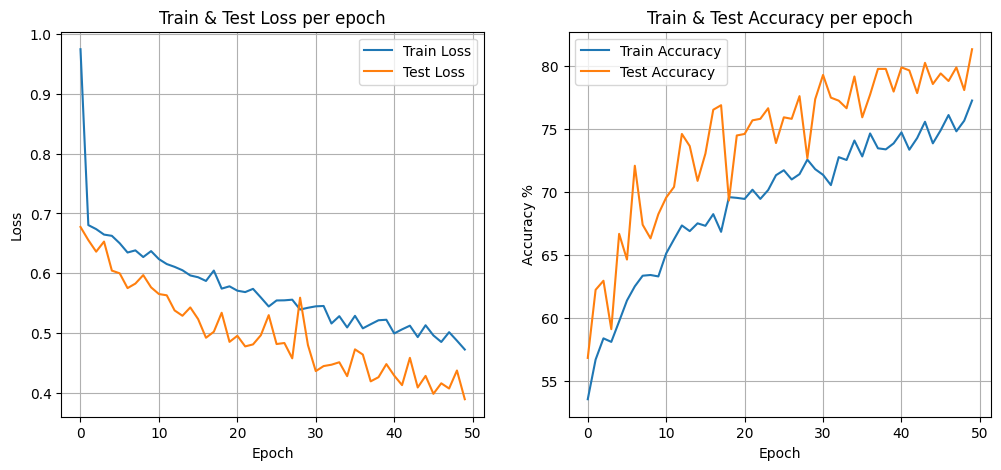

In [138]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(range(epochs), results["train_loss"], label="Train Loss")
plt.plot(range(epochs), results["test_loss"], label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Train & Test Loss per epoch")
plt.legend()
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(range(epochs), results["train_acc"], label="Train Accuracy")
plt.plot(range(epochs), results["test_acc"], label="Test Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy %")
plt.title("Train & Test Accuracy per epoch")
plt.legend()
plt.grid()

In [139]:
from torch.utils.data import Subset

In [140]:
train_100_images = Subset(train_data_augmentation, range(100))
test_20_images = Subset(test_data_augmentation, range(20))

len(train_100_images), len(test_20_images)

(100, 20)